In [53]:
import findspark
findspark.init()

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, sum, lag, when, min, count
from pyspark.sql.window import Window
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Jupyter Demo").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

In [3]:
crimes = spark.read.option("header","true").option("inferschema","true").option("delimiter", ";").csv("hdfs://localhost:8020/user/projekt/Crimes.csv")
crimes.show()

+--------+--------------------+--------------------+---------+-------------+------+--------+---------------+---+-----+----+
|      ID|        Primary_Type|         Description| Latitude|    Longitude|Arrest|Domestic|District_by_zip|Day|Month|Year|
+--------+--------------------+--------------------+---------+-------------+------+--------+---------------+---+-----+----+
|13707156|               THEFT|       FROM BUILDING| 41.85787|-87.624744613| false|   false|             40| 29|   12|2024|
|13705275|             BATTERY|              SIMPLE|41.961628|-87.666419454|  true|   false|             53| 29|   12|2024|
|13705590|     CRIMINAL DAMAGE|         TO PROPERTY| 41.76053|  -87.5929758| false|   false|             61| 29|   12|2024|
|13706702|       OTHER OFFENSE|    TELEPHONE THREAT|41.785664| -87.79621778| false|   false|              7| 29|   12|2024|
|13705229|     CRIMINAL DAMAGE|         TO PROPERTY| 41.78226|-87.622120158| false|   false|             60| 29|   12|2024|
|1370596

In [4]:
print(crimes.count())
crimes.printSchema()

[Stage 3:=============================>                             (1 + 1) / 2]

2513164
root
 |-- ID: integer (nullable = true)
 |-- Primary_Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- District_by_zip: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)



In [5]:
null_counts = crimes.select(
    *[sum(col(column).isNull().cast("int")).alias(column) for column in crimes.columns]
).toPandas()

print(null_counts.T.rename(columns={0: "null_count"}))

                 null_count
ID                        0
Primary_Type              0
Description               0
Latitude              39276
Longitude             39276
Arrest                    0
Domestic                  0
District_by_zip       46519
Day                       0
Month                     0
Year                      0


+----+------+
|Year| count|
+----+------+
|2015|264866|
|2016|269926|
|2017|269214|
|2018|269070|
|2019|261554|
|2020|212519|
|2021|209404|
|2022|239647|
|2023|262748|
|2024|254216|
+----+------+

None


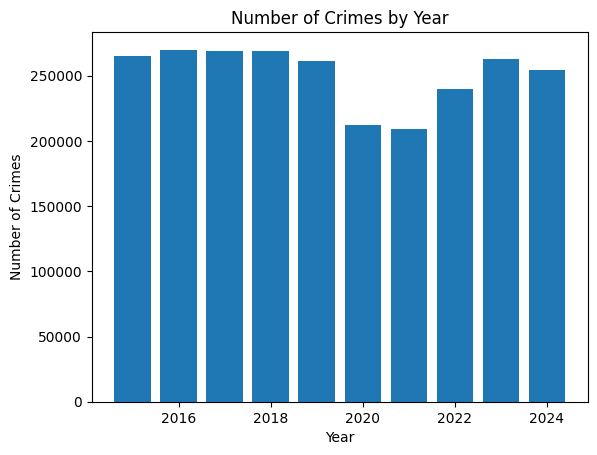

In [7]:
def bar_plot(df, group_column):
    df = df.groupBy(group_column).count().orderBy(col(group_column).asc())
    print(df.show())
    df = df.toPandas()
    plt.bar(df[group_column], df['count'])
    plt.xlabel(group_column)
    plt.ylabel("Number of Crimes")
    plt.title("Number of Crimes by " + group_column)
    plt.show()
bar_plot(crimes, "Year")

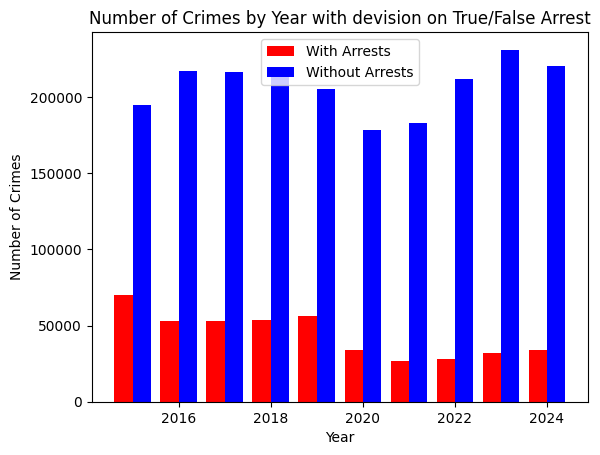

Arrest Percent True Percent False
Year                             
2015         26.45%        73.55%
2016         19.65%        80.35%
2017         19.56%        80.44%
2018         20.03%        79.97%
2019         21.51%        78.49%
2020         16.07%        83.93%
2021         12.68%        87.32%
2022         11.71%        88.29%
2023         12.12%        87.88%
2024         13.44%        86.56%


In [8]:
crimes_year_arrest_count = crimes.groupBy("Year", "Arrest").count().orderBy(col("Year").asc()).toPandas()
true_arrests = crimes_year_arrest_count[crimes_year_arrest_count['Arrest'] == True]
false_arrests = crimes_year_arrest_count[crimes_year_arrest_count['Arrest'] == False]
years = true_arrests['Year']
plt.bar(years - 0.2, true_arrests['count'], width=0.4, color='red', label='With Arrests')
plt.bar(years + 0.2, false_arrests['count'], width=0.4, color='blue', label='Without Arrests')
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.title("Number of Crimes by Year with devision on True/False Arrest")
plt.legend()
plt.show()

crimes_pivot = crimes_year_arrest_count.pivot(index='Year', columns='Arrest', values='count')
crimes_pivot['Total'] = crimes_pivot[True] + crimes_pivot[False]
crimes_pivot['Percent True'] = ((crimes_pivot[True] / crimes_pivot['Total']) * 100).round(2).astype(str) + '%'
crimes_pivot['Percent False'] = ((crimes_pivot[False] / crimes_pivot['Total']) * 100).round(2).astype(str) + '%'
print(crimes_pivot[['Percent True', 'Percent False']])

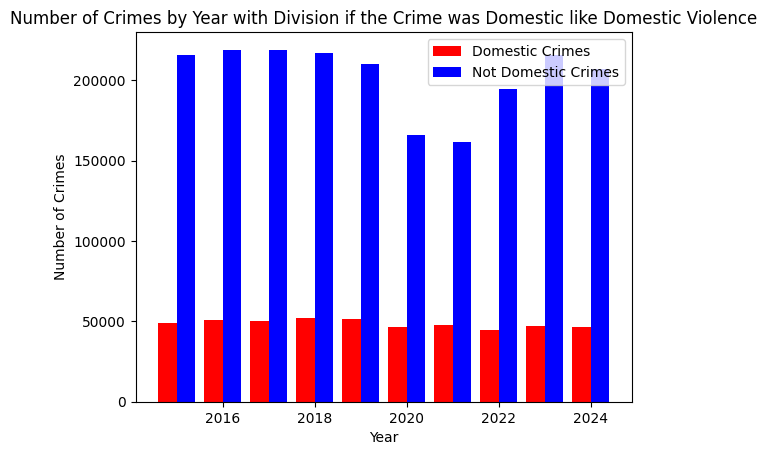

Domestic Percent True Percent False
Year                               
2015           18.49%        81.51%
2016           18.82%        81.18%
2017           18.75%        81.25%
2018           19.27%        80.73%
2019           19.58%        80.42%
2020           21.78%        78.22%
2021           22.86%        77.14%
2022           18.75%        81.25%
2023           17.88%        82.12%
2024           18.42%        81.58%


In [9]:
crimes_year_domestic_count = crimes.groupBy("Year", "Domestic").count().orderBy(col("Year").asc()).toPandas()
true_domestic = crimes_year_domestic_count[crimes_year_domestic_count['Domestic'] == True]
false_domestic = crimes_year_domestic_count[crimes_year_domestic_count['Domestic'] == False]
years = true_domestic['Year']
plt.bar(years - 0.2, true_domestic['count'], width=0.4, color='red', label='Domestic Crimes')
plt.bar(years + 0.2, false_domestic['count'], width=0.4, color='blue', label='Not Domestic Crimes')

plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.title("Number of Crimes by Year with Division if the Crime was Domestic like Domestic Violence")
plt.legend()
plt.show()

crimes_pivot = crimes_year_domestic_count.pivot(index='Year', columns='Domestic', values='count')
crimes_pivot['Total'] = crimes_pivot[True] + crimes_pivot[False]
crimes_pivot['Percent True'] = ((crimes_pivot[True] / crimes_pivot['Total']) * 100).round(2).astype(str) + '%'
crimes_pivot['Percent False'] = ((crimes_pivot[False] / crimes_pivot['Total']) * 100).round(2).astype(str) + '%'

print(crimes_pivot[['Percent True', 'Percent False']])

In [11]:
crimes_primary_type_count = crimes.groupBy("Primary_Type").count().orderBy(col("count").desc())
print(crimes_primary_type_count.show(crimes_primary_type_count.count(), truncate=False))

[Stage 40:=================================================>    (182 + 2) / 200]

+---------------------------------+------+
|Primary_Type                     |count |
+---------------------------------+------+
|THEFT                            |565152|
|BATTERY                          |460614|
|CRIMINAL DAMAGE                  |278795|
|ASSAULT                          |201413|
|DECEPTIVE PRACTICE               |180008|
|OTHER OFFENSE                    |159791|
|MOTOR VEHICLE THEFT              |144436|
|NARCOTICS                        |106649|
|BURGLARY                         |100659|
|ROBBERY                          |96000 |
|WEAPONS VIOLATION                |65859 |
|CRIMINAL TRESPASS                |54661 |
|OFFENSE INVOLVING CHILDREN       |21562 |
|PUBLIC PEACE VIOLATION           |12838 |
|SEX OFFENSE                      |11681 |
|CRIMINAL SEXUAL ASSAULT          |9056  |
|INTERFERENCE WITH PUBLIC OFFICER |8812  |
|CRIM SEXUAL ASSAULT              |6670  |
|HOMICIDE                         |6623  |
|PROSTITUTION                     |5429  |
|ARSON     

In [12]:
def filter_and_group_by(df, filter_column, filter_value, group_column):
    df = df[df[filter_column] == filter_value]
    df_count = df.groupBy(group_column).count().orderBy(col("count").desc())
    df_count.show(df_count.count(), truncate = False)
filter_and_group_by(crimes, "Primary_Type", "THEFT", "Description")

[Stage 45:====================================================> (194 + 2) / 200]

+------------------------------------+------+
|Description                         |count |
+------------------------------------+------+
|$500 AND UNDER                      |211820|
|OVER $500                           |155674|
|RETAIL THEFT                        |93796 |
|FROM BUILDING                       |75795 |
|POCKET-PICKING                      |17151 |
|PURSE-SNATCHING                     |4523  |
|ATTEMPT THEFT                       |3648  |
|THEFT FROM MOTOR VEHICLE            |2231  |
|DELIVERY CONTAINER THEFT            |351   |
|FROM COIN-OP MACHINE/DEVICE         |104   |
|FROM COIN-OPERATED MACHINE OR DEVICE|58    |
|THEFT RETAIL                        |1     |
+------------------------------------+------+



In [13]:
crimes_theft = crimes[crimes["Primary_Type"] == "THEFT"]
crimes_theft_by_year_count = crimes_theft.groupBy("Description", "Year").count().orderBy("Description","Year")
print(crimes_theft_by_year_count.show(crimes_theft_by_year_count.count(), truncate = False))

[Stage 50:===================================================>  (191 + 3) / 200]

+------------------------------------+----+-----+
|Description                         |Year|count|
+------------------------------------+----+-----+
|$500 AND UNDER                      |2015|24677|
|$500 AND UNDER                      |2016|24293|
|$500 AND UNDER                      |2017|24524|
|$500 AND UNDER                      |2018|24845|
|$500 AND UNDER                      |2019|23177|
|$500 AND UNDER                      |2020|17719|
|$500 AND UNDER                      |2021|16036|
|$500 AND UNDER                      |2022|18886|
|$500 AND UNDER                      |2023|18750|
|$500 AND UNDER                      |2024|18913|
|ATTEMPT THEFT                       |2015|348  |
|ATTEMPT THEFT                       |2016|415  |
|ATTEMPT THEFT                       |2017|408  |
|ATTEMPT THEFT                       |2018|414  |
|ATTEMPT THEFT                       |2019|429  |
|ATTEMPT THEFT                       |2020|288  |
|ATTEMPT THEFT                       |2021|240  |


In [33]:
crimes_by_year_count = crimes.groupBy("Primary_Type", "Description", "Year").count().orderBy("Primary_Type", "Description","Year")
print(crimes_by_year_count.show())
print(crimes_by_year_count.count())
pd.DataFrame([crimes_by_year_count]).to_csv('crimes_by_year_count.csv', index=False)

+------------+-------------+----+-----+
|Primary_Type|  Description|Year|count|
+------------+-------------+----+-----+
|       ARSON|   AGGRAVATED|2015|   77|
|       ARSON|   AGGRAVATED|2016|   74|
|       ARSON|   AGGRAVATED|2017|   56|
|       ARSON|   AGGRAVATED|2018|   60|
|       ARSON|   AGGRAVATED|2019|   59|
|       ARSON|   AGGRAVATED|2020|   44|
|       ARSON|   AGGRAVATED|2021|   45|
|       ARSON|   AGGRAVATED|2022|   35|
|       ARSON|   AGGRAVATED|2023|   43|
|       ARSON|   AGGRAVATED|2024|   21|
|       ARSON|ATTEMPT ARSON|2015|   57|
|       ARSON|ATTEMPT ARSON|2016|   75|
|       ARSON|ATTEMPT ARSON|2017|   50|
|       ARSON|ATTEMPT ARSON|2018|   42|
|       ARSON|ATTEMPT ARSON|2019|   51|
|       ARSON|ATTEMPT ARSON|2020|   63|
|       ARSON|ATTEMPT ARSON|2021|   63|
|       ARSON|ATTEMPT ARSON|2022|   41|
|       ARSON|ATTEMPT ARSON|2023|   65|
|       ARSON|ATTEMPT ARSON|2024|   57|
+------------+-------------+----+-----+
only showing top 20 rows

None


3687


In [39]:
# window_spec = Window.partitionBy('Primary_Type', 'Description').orderBy('Year')
# crimes_by_year_count_2 = crimes_by_year_count.withColumn("count_diff", col("count") - lag("count").over(window_spec))
# crimes_by_year_count_2 = crimes_by_year_count_2.groupBy("Primary_Type", "Description").agg(
#         sum(when(col("count_diff") > 0, col("count_diff")).otherwise(0)).alias("positive_sum"),
#         sum(when(col("count_diff") < 0, col("count_diff")).otherwise(0)).alias("negative_sum"))

# print(crimes_by_year_count_2.orderBy(col("positive_sum").desc()).show())
# print(crimes_by_year_count_2.orderBy(col("negative_sum").asc()).show())
crimes_by_year_count_2[(crimes_by_year_count_2["positive_sum"] == 0) & (crimes_by_year_count_2["negative_sum"] < 0)].orderBy(col("negative_sum").asc()).show()

[Stage 293:===================================================> (193 + 3) / 200]

+-------------------+--------------------+------------+------------+
|       Primary_Type|         Description|positive_sum|negative_sum|
+-------------------+--------------------+------------+------------+
|      OTHER OFFENSE|    PAROLE VIOLATION|           0|       -1985|
|          NARCOTICS|MANU/DELIVER: HAL...|           0|         -39|
|      OTHER OFFENSE|SEX OFFENDER: PRO...|           0|         -21|
| DECEPTIVE PRACTICE|UNLAWFUL USE OF R...|           0|         -17|
|     NON - CRIMINAL|   FOID - REVOCATION|           0|         -15|
|  WEAPONS VIOLATION|DEFACE IDENTIFICA...|           0|          -6|
|  WEAPONS VIOLATION|UNLAWFUL SALE OTH...|           0|          -5|
|        SEX OFFENSE|INDECENT SOLICITA...|           0|          -5|
|            BATTERY|AGGRAVATED PO: HA...|           0|          -5|
|          NARCOTICS|CONT SUBS:FAIL TO...|           0|          -5|
|MOTOR VEHICLE THEFT|THEFT/RECOVERY: C...|           0|          -4|
| DECEPTIVE PRACTICE|UNIDENTIFIABL

In [40]:
crimes_by_year_count[crimes_by_year_count["Description"] == "PAROLE VIOLATION"].show()

[Stage 295:===============================================>     (178 + 2) / 200]

+-------------+----------------+----+-----+
| Primary_Type|     Description|Year|count|
+-------------+----------------+----+-----+
|OTHER OFFENSE|PAROLE VIOLATION|2015| 1986|
|OTHER OFFENSE|PAROLE VIOLATION|2016|  854|
|OTHER OFFENSE|PAROLE VIOLATION|2017|  653|
|OTHER OFFENSE|PAROLE VIOLATION|2018|   46|
|OTHER OFFENSE|PAROLE VIOLATION|2019|   17|
|OTHER OFFENSE|PAROLE VIOLATION|2020|    6|
|OTHER OFFENSE|PAROLE VIOLATION|2021|    2|
|OTHER OFFENSE|PAROLE VIOLATION|2022|    1|
|OTHER OFFENSE|PAROLE VIOLATION|2023|    1|
|OTHER OFFENSE|PAROLE VIOLATION|2024|    1|
+-------------+----------------+----+-----+



In [18]:
crimes_2024_count = crimes_2024.groupBy("Day", "Month").count().orderBy("Month", "Day")
crimes_2024_count.show(crimes_2024_count.count(), truncate = False)

[Stage 52:==================================================>   (187 + 2) / 200]

+---+-----+-----+
|Day|Month|count|
+---+-----+-----+
|1  |1    |945  |
|2  |1    |652  |
|3  |1    |675  |
|4  |1    |690  |
|5  |1    |677  |
|6  |1    |634  |
|7  |1    |643  |
|8  |1    |653  |
|9  |1    |548  |
|10 |1    |678  |
|11 |1    |641  |
|12 |1    |554  |
|13 |1    |537  |
|14 |1    |397  |
|15 |1    |493  |
|16 |1    |490  |
|17 |1    |566  |
|18 |1    |592  |
|19 |1    |580  |
|20 |1    |556  |
|21 |1    |540  |
|22 |1    |601  |
|23 |1    |641  |
|24 |1    |628  |
|25 |1    |701  |
|26 |1    |715  |
|27 |1    |674  |
|28 |1    |710  |
|29 |1    |682  |
|30 |1    |726  |
|31 |1    |702  |
|1  |2    |762  |
|2  |2    |691  |
|3  |2    |654  |
|4  |2    |679  |
|5  |2    |722  |
|6  |2    |697  |
|7  |2    |715  |
|8  |2    |707  |
|9  |2    |744  |
|10 |2    |707  |
|11 |2    |642  |
|12 |2    |667  |
|13 |2    |655  |
|14 |2    |687  |
|15 |2    |657  |
|16 |2    |703  |
|17 |2    |654  |
|18 |2    |678  |
|19 |2    |674  |
|20 |2    |668  |
|21 |2    |682  |
|22 |2    

In [47]:
# bar_plot(crimes, "District_by_zip")
# print(crimes.groupBy("District_by_zip").count().count())
# print(crimes.groupBy("District_by_zip").count().orderBy(col("count").asc()).head(5))
# print(crimes.groupBy("District_by_zip").count().orderBy(col("count").desc()).head(5))
crimes_by_zip_count = crimes.groupBy("District_by_zip", "Year").count().orderBy("District_by_zip", "Year")
print(crimes_by_zip_count.show())
print(crimes_by_zip_count.count())
pd.DataFrame([crimes_by_zip_count]).to_csv('crimes_by_zip_count.csv', index=False)

+---------------+----+-----+
|District_by_zip|Year|count|
+---------------+----+-----+
|           null|2015| 7586|
|           null|2016| 3373|
|           null|2017| 4939|
|           null|2018| 6281|
|           null|2019| 3097|
|           null|2020| 5144|
|           null|2021| 7126|
|           null|2022| 5519|
|           null|2023| 2394|
|           null|2024| 1060|
|              1|2015| 5440|
|              1|2016| 6282|
|              1|2017| 6011|
|              1|2018| 5684|
|              1|2019| 5698|
|              1|2020| 4333|
|              1|2021| 4087|
|              1|2022| 4741|
|              1|2023| 5996|
|              1|2024| 6118|
+---------------+----+-----+
only showing top 20 rows

None


[Stage 324:===================================================> (194 + 2) / 200]

620


In [50]:
# window_spec = Window.partitionBy("District_by_zip").orderBy('Year')
# crimes_by_zip_count_2 = crimes_by_zip_count.withColumn("count_diff", col("count") - lag("count").over(window_spec))
# crimes_by_zip_count_2 = crimes_by_zip_count_2.groupBy("District_by_zip").agg(
#         sum(when(col("count_diff") > 0, col("count_diff")).otherwise(0)).alias("positive_sum"),
#         sum(when(col("count_diff") < 0, col("count_diff")).otherwise(0)).alias("negative_sum"))

# print(crimes_by_zip_count_2.orderBy(col("positive_sum").desc()).show())
# print(crimes_by_zip_count_2.orderBy(col("negative_sum").asc()).show())
# crimes_by_zip_count_2[(crimes_by_zip_count_2["positive_sum"] == 0) & (crimes_by_zip_count_2["negative_sum"] < 0)].orderBy(col("negative_sum").asc()).show()
crimes_by_zip_count_2[(crimes_by_zip_count_2["positive_sum"] > 0) & (crimes_by_zip_count_2["negative_sum"] == 0)].orderBy(col("positive_sum").desc()).show()

[Stage 349:=================================================>   (187 + 2) / 200]

+---------------+------------+------------+
|District_by_zip|positive_sum|negative_sum|
+---------------+------------+------------+
+---------------+------------+------------+



In [23]:
crimes_count = crimes.groupBy("Day", "Month", "Year").count()
print(crimes_count.orderBy(col("count").desc()).show())
print(crimes_count.orderBy(col("count").asc()).show())

+---+-----+----+-----+
|Day|Month|Year|count|
+---+-----+----+-----+
| 31|    5|2020| 1899|
|  1|    1|2015| 1276|
|  1|    1|2017| 1253|
|  1|    1|2016| 1197|
|  1|    1|2019| 1136|
|  1|    1|2023| 1066|
|  1|    1|2020| 1062|
|  1|    8|2015| 1051|
|  1|    9|2016| 1042|
|  1|    6|2018| 1027|
|  1|    5|2018| 1017|
|  1|    1|2018| 1017|
|  1|   11|2015|  998|
|  1|    7|2018|  992|
|  1|    9|2018|  988|
|  1|    7|2016|  967|
|  1|    8|2017|  965|
|  1|    9|2015|  960|
|  1|    6|2015|  957|
|  1|    5|2015|  956|
+---+-----+----+-----+
only showing top 20 rows

None


[Stage 68:=================================================>    (183 + 3) / 200]

+---+-----+----+-----+
|Day|Month|Year|count|
+---+-----+----+-----+
| 29|   12|2024|   18|
| 15|    2|2021|  340|
| 31|    1|2021|  343|
| 30|    1|2019|  344|
| 19|    4|2020|  344|
| 16|    2|2021|  366|
| 14|    4|2020|  369|
|  2|    4|2020|  376|
| 22|    3|2020|  378|
|  7|    2|2021|  383|
| 12|    4|2020|  386|
| 31|    3|2020|  389|
| 24|   12|2022|  392|
| 25|   12|2017|  394|
| 26|   11|2020|  395|
| 23|    3|2020|  397|
| 14|    1|2024|  397|
| 13|    4|2020|  399|
|  2|    2|2022|  399|
| 25|    4|2020|  400|
+---+-----+----+-----+
only showing top 20 rows

None


In [57]:
crimes[crimes["Year"] == 2016].count()

269926

In [62]:
# crimes[crimes["ID"] == 13707156].show()
# crimes[crimes["ID"] == 12132715].show()
# crimes[crimes["ID"] == 12914394].show()
# crimes[crimes["ID"] == 13370689].show()
crimes[crimes["ID"] == 13370834].show()


[Stage 379:>                                                        (0 + 1) / 1]

+--------+------------+-----------+--------+-------------+------+--------+---------------+---+-----+----+
|      ID|Primary_Type|Description|Latitude|    Longitude|Arrest|Domestic|District_by_zip|Day|Month|Year|
+--------+------------+-----------+--------+-------------+------+--------+---------------+---+-----+----+
|13370834|     ASSAULT|     SIMPLE|41.85785|-87.662994729| false|    true|             43| 16|    2|2024|
+--------+------------+-----------+--------+-------------+------+--------+---------------+---+-----+----+



In [77]:
crimes.groupBy("LATITUDE", "LONGITUDE").count().orderBy(col("count").desc()).show()

[Stage 442:=================================================>   (188 + 2) / 200]

+---------+-------------+-----+
| LATITUDE|    LONGITUDE|count|
+---------+-------------+-----+
|     null|         null|39276|
|  41.8835|-87.627876698| 3979|
|41.754593|-87.741528537| 2494|
| 41.97629|-87.905227221| 2419|
| 41.86854|-87.639235361| 1930|
|41.897896|-87.624096605| 1736|
|41.788986| -87.74147999| 1667|
|41.976765|-87.900983721| 1533|
|41.979008|-87.906463155| 1497|
| 41.86818|-87.709271389| 1484|
|41.891693|-87.626155832| 1416|
| 41.74271|-87.634088181| 1369|
|41.909664|-87.742728815| 1323|
|41.868217|  -87.6304532| 1303|
|41.881718|-87.627760426| 1302|
|42.019398|-87.675049485| 1276|
|41.882393|-87.627844798| 1232|
|41.895004| -87.62152816| 1173|
| 41.96307|-87.655984213| 1151|
| 41.89941|-87.624131266| 1030|
+---------+-------------+-----+
only showing top 20 rows



In [79]:
crimes[(crimes["LATITUDE"] == 41.8835) & (crimes["LONGITUDE"] == -87.627876698)].groupBy("Primary_Type").count().orderBy(col("count").desc()).show()

[Stage 446:======================================>              (145 + 2) / 200]

+--------------------+-----+
|        Primary_Type|count|
+--------------------+-----+
|               THEFT| 3276|
|  DECEPTIVE PRACTICE|  447|
|             BATTERY|   67|
|   CRIMINAL TRESPASS|   56|
|             ASSAULT|   41|
|            BURGLARY|   25|
|     CRIMINAL DAMAGE|   18|
|             ROBBERY|   15|
|       OTHER OFFENSE|   12|
|         SEX OFFENSE|    8|
|PUBLIC PEACE VIOL...|    5|
|            STALKING|    3|
| MOTOR VEHICLE THEFT|    2|
|           NARCOTICS|    2|
|          KIDNAPPING|    1|
|   WEAPONS VIOLATION|    1|
+--------------------+-----+



In [55]:
traffic_crashes = spark.read.option("header","true").option("inferschema","true").option("delimiter", ";").csv("hdfs://localhost:8020/user/projekt/Traffic_Crashes.csv")
print(traffic_crashes.count())
traffic_crashes.printSchema()

[Stage 516:>                                                        (0 + 2) / 2]

907414
root
 |-- CRASH_RECORD_ID: string (nullable = true)
 |-- POSTED_SPEED_LIMIT: integer (nullable = true)
 |-- WEATHER_CONDITION: string (nullable = true)
 |-- LIGHTING_CONDITION: string (nullable = true)
 |-- ROADWAY_SURFACE_COND: string (nullable = true)
 |-- CRASH_TYPE: string (nullable = true)
 |-- NUM_UNITS: integer (nullable = true)
 |-- MOST_SEVERE_INJURY: string (nullable = true)
 |-- INJURIES_TOTAL: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- District_by_zip: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)



In [57]:
# traffic_crashes[traffic_crashes["CRASH_RECORD_ID"] == "56f859f0cbc3c80186e64164a97d39185d30d4dba17a790d9187a04aabcf69bb694f5d158a587026c9057098fb3c94ee6e1a07a0079504a2fbce21b9821449cd"].show()

[Stage 519:>                                                        (0 + 1) / 1]

+--------------------+------------------+-----------------+------------------+--------------------+--------------------+---------+--------------------+--------------+---------+-------------+---------------+---+-----+----+
|     CRASH_RECORD_ID|POSTED_SPEED_LIMIT|WEATHER_CONDITION|LIGHTING_CONDITION|ROADWAY_SURFACE_COND|          CRASH_TYPE|NUM_UNITS|  MOST_SEVERE_INJURY|INJURIES_TOTAL| LATITUDE|    LONGITUDE|District_by_zip|Day|Month|Year|
+--------------------+------------------+-----------------+------------------+--------------------+--------------------+---------+--------------------+--------------+---------+-------------+---------------+---+-----+----+
|56f859f0cbc3c8018...|                30|            CLEAR|          DAYLIGHT|                 DRY|NO INJURY / DRIVE...|        2|NO INDICATION OF ...|             0|41.775627|-87.672749141|             23| 17|   12|2017|
+--------------------+------------------+-----------------+------------------+--------------------+-------------

In [58]:
traffic_crashes[traffic_crashes["CRASH_RECORD_ID"] == "ba1f851cad8090377b9b21c29465085fb94306c59face8103e791404f8780225cb208971a69dd89c301bf9cc63679dae96d859145f05b2db3a5ab064e04f1a7f"].show()

[Stage 521:>                                                        (0 + 1) / 1]

+--------------------+------------------+-----------------+--------------------+--------------------+--------------------+---------+--------------------+--------------+--------+-------------+---------------+---+-----+----+
|     CRASH_RECORD_ID|POSTED_SPEED_LIMIT|WEATHER_CONDITION|  LIGHTING_CONDITION|ROADWAY_SURFACE_COND|          CRASH_TYPE|NUM_UNITS|  MOST_SEVERE_INJURY|INJURIES_TOTAL|LATITUDE|    LONGITUDE|District_by_zip|Day|Month|Year|
+--------------------+------------------+-----------------+--------------------+--------------------+--------------------+---------+--------------------+--------------+--------+-------------+---------------+---+-----+----+
|ba1f851cad8090377...|                30|             SNOW|DARKNESS, LIGHTED...|       SNOW OR SLUSH|NO INJURY / DRIVE...|        2|NO INDICATION OF ...|             0|41.92485|-87.704755958|              1|  5|    1|2025|
+--------------------+------------------+-----------------+--------------------+--------------------+-------

In [54]:
traffic_crashes.select(traffic_crashes.columns[:7]).show()
traffic_crashes.select(traffic_crashes.columns[7:]).show()

+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+---------+
|     CRASH_RECORD_ID|POSTED_SPEED_LIMIT|   WEATHER_CONDITION|  LIGHTING_CONDITION|ROADWAY_SURFACE_COND|          CRASH_TYPE|NUM_UNITS|
+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+---------+
|ba1f851cad8090377...|                30|                SNOW|DARKNESS, LIGHTED...|       SNOW OR SLUSH|NO INJURY / DRIVE...|        2|
|388dff558206fa2a9...|                30|                SNOW|DARKNESS, LIGHTED...|       SNOW OR SLUSH|INJURY AND / OR T...|        3|
|3b14d33e87459dc88...|                30|                SNOW|DARKNESS, LIGHTED...|       SNOW OR SLUSH|INJURY AND / OR T...|        1|
|aa8bb8aafbebd17d2...|                30|FREEZING RAIN/DRI...|DARKNESS, LIGHTED...|                 ICE|INJURY AND / OR T...|        2|
|5a3068a036e578888...|                15|       

+----+------+
|Year| count|
+----+------+
|2018|118950|
|2019|117762|
|2020| 92093|
|2021|108765|
|2022|108410|
|2023|110746|
|2024|111937|
+----+------+

None


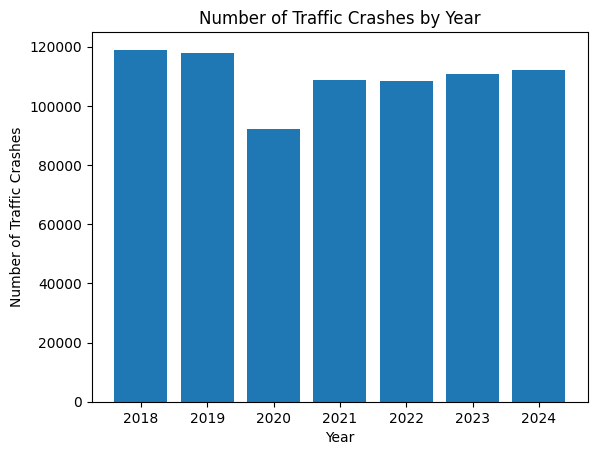

In [82]:
def bar_plot(df, group_column):
    df = df.groupBy(group_column).count().orderBy(col(group_column).asc())
    print(df.show())
    df = df.toPandas()
    plt.bar(df[group_column], df['count'])
    plt.xlabel(group_column)
    plt.ylabel("Number of Traffic Crashes")
    plt.title("Number of Traffic Crashes by " + group_column)
    plt.show()
bar_plot(traffic_crashes, "Year")

In [39]:
traffic_crashes = traffic_crashes[(traffic_crashes["Year"] >= 2018) & (traffic_crashes["Year"] < 2025)]
print(traffic_crashes.count())

[Stage 491:============================>                            (1 + 1) / 2]

768663


In [65]:
null_counts = traffic_crashes.select(
    *[sum(col(column).isNull().cast("int")).alias(column) for column in traffic_crashes.columns]
).toPandas()

print(null_counts.T.rename(columns={0: "null_count"}))

[Stage 389:============================>                            (1 + 1) / 2]

                      null_count
CRASH_RECORD_ID                0
POSTED_SPEED_LIMIT             0
WEATHER_CONDITION              0
LIGHTING_CONDITION             0
ROADWAY_SURFACE_COND           0
CRASH_TYPE                     0
NUM_UNITS                      0
MOST_SEVERE_INJURY          1779
INJURIES_TOTAL              1772
LATITUDE                    6016
LONGITUDE                   6016
District_by_zip             6380
Day                            0
Month                          0
Year                           0


+--------------+------+
|INJURIES_TOTAL| count|
+--------------+------+
|          null|  1772|
|             0|652266|
|             1| 85923|
|             2| 19420|
|             3|  5920|
|             4|  2093|
|             5|   739|
|             6|   291|
|             7|   124|
|             8|    45|
|             9|    25|
|            10|    14|
|            11|     7|
|            12|     6|
|            13|     2|
|            14|     1|
|            15|     8|
|            16|     1|
|            17|     1|
|            19|     1|
+--------------+------+
only showing top 20 rows

None


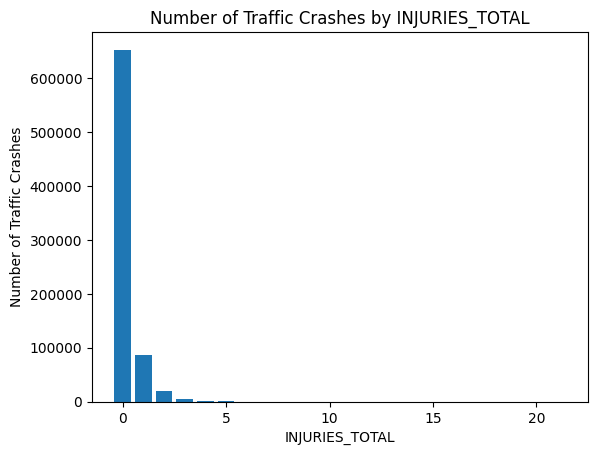

In [83]:
bar_plot(traffic_crashes, "INJURIES_TOTAL")

+------------------+-----+
|POSTED_SPEED_LIMIT|count|
+------------------+-----+
|                 0| 4072|
|                 1|   22|
|                 2|   23|
|                 3|  195|
|                 4|    1|
|                 5| 3595|
|                 6|    5|
|                 7|    5|
|                 8|    2|
|                 9|   29|
|                10|18697|
|                11|   11|
|                12|    3|
|                14|    4|
|                15|27948|
|                16|    1|
|                18|    2|
|                20|33109|
|                22|    4|
|                23|    3|
+------------------+-----+
only showing top 20 rows

None


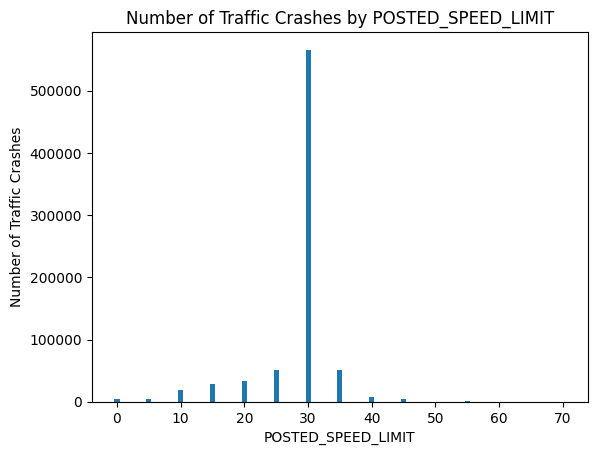

In [84]:
bar_plot(traffic_crashes, "POSTED_SPEED_LIMIT")

+--------------------+------+
|          CRASH_TYPE| count|
+--------------------+------+
|INJURY AND / OR T...|221509|
|NO INJURY / DRIVE...|547154|
+--------------------+------+

None


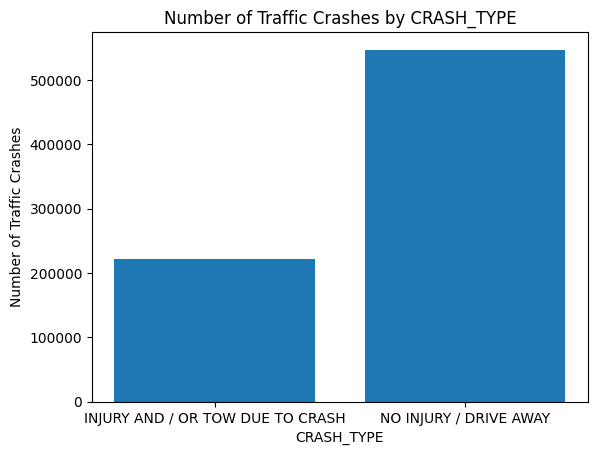

In [85]:
bar_plot(traffic_crashes, "CRASH_TYPE")

In [71]:
traffic_crashes_count = traffic_crashes.groupBy("WEATHER_CONDITION", "Year").count().orderBy("WEATHER_CONDITION", "Year")
traffic_crashes_count.show(traffic_crashes_count.count(), truncate = False)

[Stage 430:====================================================>(198 + 2) / 200]

+------------------------+----+-----+
|WEATHER_CONDITION       |Year|count|
+------------------------+----+-----+
|BLOWING SAND, SOIL, DIRT|2020|2    |
|BLOWING SAND, SOIL, DIRT|2022|2    |
|BLOWING SAND, SOIL, DIRT|2023|3    |
|BLOWING SAND, SOIL, DIRT|2024|1    |
|BLOWING SNOW            |2019|25   |
|BLOWING SNOW            |2020|50   |
|BLOWING SNOW            |2021|94   |
|BLOWING SNOW            |2022|179  |
|BLOWING SNOW            |2023|55   |
|BLOWING SNOW            |2024|55   |
|CLEAR                   |2018|94006|
|CLEAR                   |2019|91604|
|CLEAR                   |2020|74200|
|CLEAR                   |2021|86703|
|CLEAR                   |2022|83687|
|CLEAR                   |2023|83968|
|CLEAR                   |2024|87643|
|CLOUDY/OVERCAST         |2018|3853 |
|CLOUDY/OVERCAST         |2019|3885 |
|CLOUDY/OVERCAST         |2020|2509 |
|CLOUDY/OVERCAST         |2021|3180 |
|CLOUDY/OVERCAST         |2022|2966 |
|CLOUDY/OVERCAST         |2023|3373 |
|CLOUDY/OVER

In [75]:
traffic_crashes.groupBy("WEATHER_CONDITION", "LIGHTING_CONDITION", "ROADWAY_SURFACE_COND", "POSTED_SPEED_LIMIT").count().orderBy(col("count").desc()).show()

[Stage 438:==============================================>      (177 + 3) / 200]

+-----------------+--------------------+--------------------+------------------+------+
|WEATHER_CONDITION|  LIGHTING_CONDITION|ROADWAY_SURFACE_COND|POSTED_SPEED_LIMIT| count|
+-----------------+--------------------+--------------------+------------------+------+
|            CLEAR|            DAYLIGHT|                 DRY|                30|277391|
|            CLEAR|DARKNESS, LIGHTED...|                 DRY|                30| 87636|
|             RAIN|            DAYLIGHT|                 WET|                30| 24741|
|            CLEAR|            DAYLIGHT|                 DRY|                35| 24268|
|            CLEAR|            DAYLIGHT|                 DRY|                25| 23707|
|          UNKNOWN|             UNKNOWN|             UNKNOWN|                30| 19069|
|            CLEAR|            DAYLIGHT|                 DRY|                20| 16334|
|            CLEAR|            DARKNESS|                 DRY|                30| 16037|
|             RAIN|DARKNESS, LIG

In [76]:
traffic_crashes.groupBy("LATITUDE", "LONGITUDE").count().orderBy(col("count").desc()).show()

+---------+-------------+-----+
| LATITUDE|    LONGITUDE|count|
+---------+-------------+-----+
|     null|         null| 6016|
|  41.9762|-87.905309125| 1339|
| 41.90096|-87.619928174|  767|
| 41.79142|-87.580147769|  524|
| 41.75146|-87.585971993|  519|
|41.722256|-87.585275565|  408|
| 41.75466|-87.741384759|  321|
|41.880856|-87.617635892|  312|
|41.900753|   -87.624235|  303|
| 41.73621|-87.624305519|  282|
|41.896805|-87.617027423|  280|
| 41.78933|-87.741645644|  269|
| 41.92616|-87.631514665|  267|
| 41.71412|-87.643145408|  256|
|41.736824| -87.58578342|  239|
| 41.87831|-87.617575903|  233|
|41.736164|-87.625587569|  227|
|41.892094|-87.611569884|  214|
| 41.80838|-87.684570717|  214|
|41.721367|-87.643358042|  207|
+---------+-------------+-----+
only showing top 20 rows



+-----+-----+
|Month|count|
+-----+-----+
|    1|58935|
|    2|58634|
|    3|59790|
|    4|58489|
|    5|68328|
|    6|68649|
|    7|68481|
|    8|68229|
|    9|66958|
|   10|68859|
|   11|61351|
|   12|61960|
+-----+-----+

None


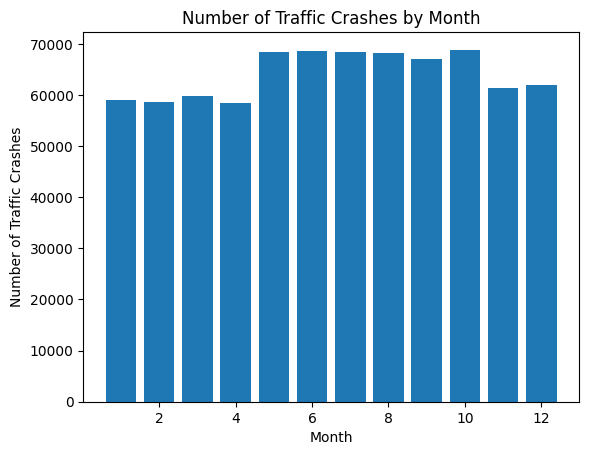

In [86]:
bar_plot(traffic_crashes, "Month")

In [8]:
# bar_plot(traffic_crashes, "District_by_zip")
# print(traffic_crashes.groupBy("District_by_zip").count().count())
# print(traffic_crashes.groupBy("District_by_zip").count().orderBy(col("count").asc()).head(5))
# print(traffic_crashes.groupBy("District_by_zip").count().orderBy(col("count").desc()).head(5))
traffic_crashes_by_zip_count = traffic_crashes.groupBy("District_by_zip", "Year").count().orderBy("District_by_zip", "Year")
print(traffic_crashes_by_zip_count.show())
print(traffic_crashes_by_zip_count.count())
pd.DataFrame([traffic_crashes_by_zip_count]).to_csv('traffic_crashes_by_zip_count.csv', index=False)

+---------------+----+-----+
|District_by_zip|Year|count|
+---------------+----+-----+
|           null|2018|  523|
|           null|2019|  976|
|           null|2020|  643|
|           null|2021|  887|
|           null|2022| 1015|
|           null|2023| 1097|
|           null|2024| 1239|
|              1|2018| 3149|
|              1|2019| 2857|
|              1|2020| 1935|
|              1|2021| 2425|
|              1|2022| 2598|
|              1|2023| 2711|
|              1|2024| 2789|
|              2|2018| 3286|
|              2|2019| 3452|
|              2|2020| 2734|
|              2|2021| 3037|
|              2|2022| 3197|
|              2|2023| 3285|
+---------------+----+-----+
only showing top 20 rows

None


[Stage 16:===================================================>  (190 + 2) / 200]

434


In [11]:
traffic_crashes_to_analize = traffic_crashes.groupBy("Year", "Month", "District_by_zip").pivot("CRASH_TYPE").agg(count("*").alias("count"))
traffic_crashes_to_analize.show()

+----+-----+---------------+--------------------------------+----------------------+
|Year|Month|District_by_zip|INJURY AND / OR TOW DUE TO CRASH|NO INJURY / DRIVE AWAY|
+----+-----+---------------+--------------------------------+----------------------+
|2021|   12|              3|                              13|                    38|
|2021|    2|             29|                               2|                     6|
|2023|    5|             18|                              22|                    57|
|2022|    6|             50|                              29|                    87|
|2021|    7|             24|                              77|                   130|
|2019|    6|             15|                              46|                   142|
|2024|   12|             39|                              44|                   183|
|2020|    2|             23|                              42|                   109|
|2018|    4|              5|                              78|    

In [12]:
crimes_to_analize = crimes.groupBy("Year", "Month", "District_by_zip").pivot("Primary_Type").agg(count("*").alias("count"))
crimes_to_analize.show()

+----+-----+---------------+-----+-------+-------+--------+---------------------------------+-------------------+---------------+-----------------------+-----------------+------------------+--------+--------+-----------------+--------------------------------+------------+----------+--------------------+-------------------+---------+--------------+------------+--------------------------------+---------+--------------------------+------------------------+-------------+------------+----------------+----------------------+---------+-------+-----------+--------+-----+-----------------+
|Year|Month|District_by_zip|ARSON|ASSAULT|BATTERY|BURGLARY|CONCEALED CARRY LICENSE VIOLATION|CRIM SEXUAL ASSAULT|CRIMINAL DAMAGE|CRIMINAL SEXUAL ASSAULT|CRIMINAL TRESPASS|DECEPTIVE PRACTICE|GAMBLING|HOMICIDE|HUMAN TRAFFICKING|INTERFERENCE WITH PUBLIC OFFICER|INTIMIDATION|KIDNAPPING|LIQUOR LAW VIOLATION|MOTOR VEHICLE THEFT|NARCOTICS|NON - CRIMINAL|NON-CRIMINAL|NON-CRIMINAL (SUBJECT SPECIFIED)|OBSCENITY|OFFENSE

In [15]:
joined = traffic_crashes_to_analize.join(crimes_to_analize, on=["Year", "Month", "District_by_zip"], how="left")
joined = joined.fillna(0)
joined.show()

+----+-----+---------------+--------------------------------+----------------------+-----+-------+-------+--------+---------------------------------+-------------------+---------------+-----------------------+-----------------+------------------+--------+--------+-----------------+--------------------------------+------------+----------+--------------------+-------------------+---------+--------------+------------+--------------------------------+---------+--------------------------+------------------------+-------------+------------+----------------+----------------------+---------+-------+-----------+--------+-----+-----------------+
|Year|Month|District_by_zip|INJURY AND / OR TOW DUE TO CRASH|NO INJURY / DRIVE AWAY|ARSON|ASSAULT|BATTERY|BURGLARY|CONCEALED CARRY LICENSE VIOLATION|CRIM SEXUAL ASSAULT|CRIMINAL DAMAGE|CRIMINAL SEXUAL ASSAULT|CRIMINAL TRESPASS|DECEPTIVE PRACTICE|GAMBLING|HOMICIDE|HUMAN TRAFFICKING|INTERFERENCE WITH PUBLIC OFFICER|INTIMIDATION|KIDNAPPING|LIQUOR LAW VIOLAT

In [24]:
numeric_cols = [
    'District_by_zip', 'INJURY AND / OR TOW DUE TO CRASH', 'NO INJURY / DRIVE AWAY'
]
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df = assembler.transform(joined)

correlation_matrix = Correlation.corr(df, "features", method="pearson").head()[0]
corr_array = correlation_matrix.toArray()

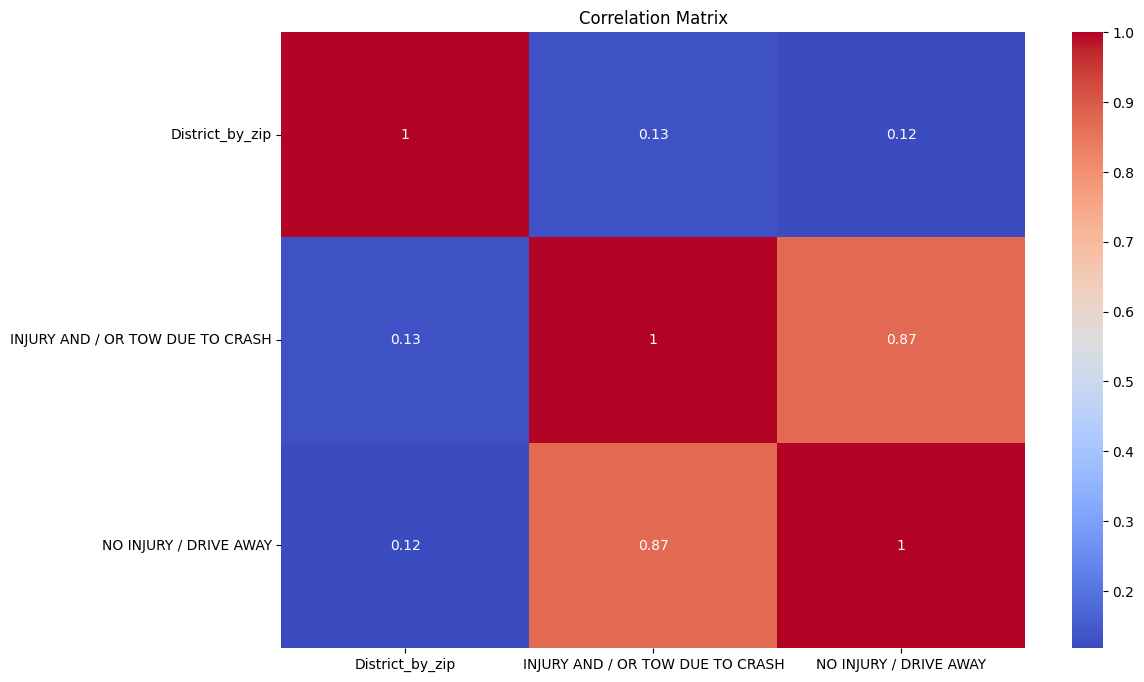

In [25]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_array, annot=True, cmap="coolwarm", xticklabels=numeric_cols, yticklabels=numeric_cols)
plt.title("Correlation Matrix")
plt.show()

In [27]:
numeric_cols = [
    'District_by_zip', 'ARSON', 'ASSAULT',
    'BATTERY', 'BURGLARY', 'CONCEALED CARRY LICENSE VIOLATION', 'CRIM SEXUAL ASSAULT',
    'CRIMINAL DAMAGE', 'CRIMINAL SEXUAL ASSAULT', 'CRIMINAL TRESPASS', 'DECEPTIVE PRACTICE',
    'GAMBLING', 'HOMICIDE', 'HUMAN TRAFFICKING', 'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION',
    'KIDNAPPING', 'LIQUOR LAW VIOLATION', 'MOTOR VEHICLE THEFT', 'NARCOTICS', 'NON - CRIMINAL',
    'OBSCENITY', 'OFFENSE INVOLVING CHILDREN', 'OTHER NARCOTIC VIOLATION', 'OTHER OFFENSE', 'PROSTITUTION',
    'PUBLIC INDECENCY', 'PUBLIC PEACE VIOLATION', 'RITUALISM', 'ROBBERY', 'SEX OFFENSE', 'STALKING',
    'THEFT', 'WEAPONS VIOLATION']
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df = assembler.transform(joined)

correlation_matrix = Correlation.corr(df, "features", method="pearson").head()[0]
corr_array = correlation_matrix.toArray()

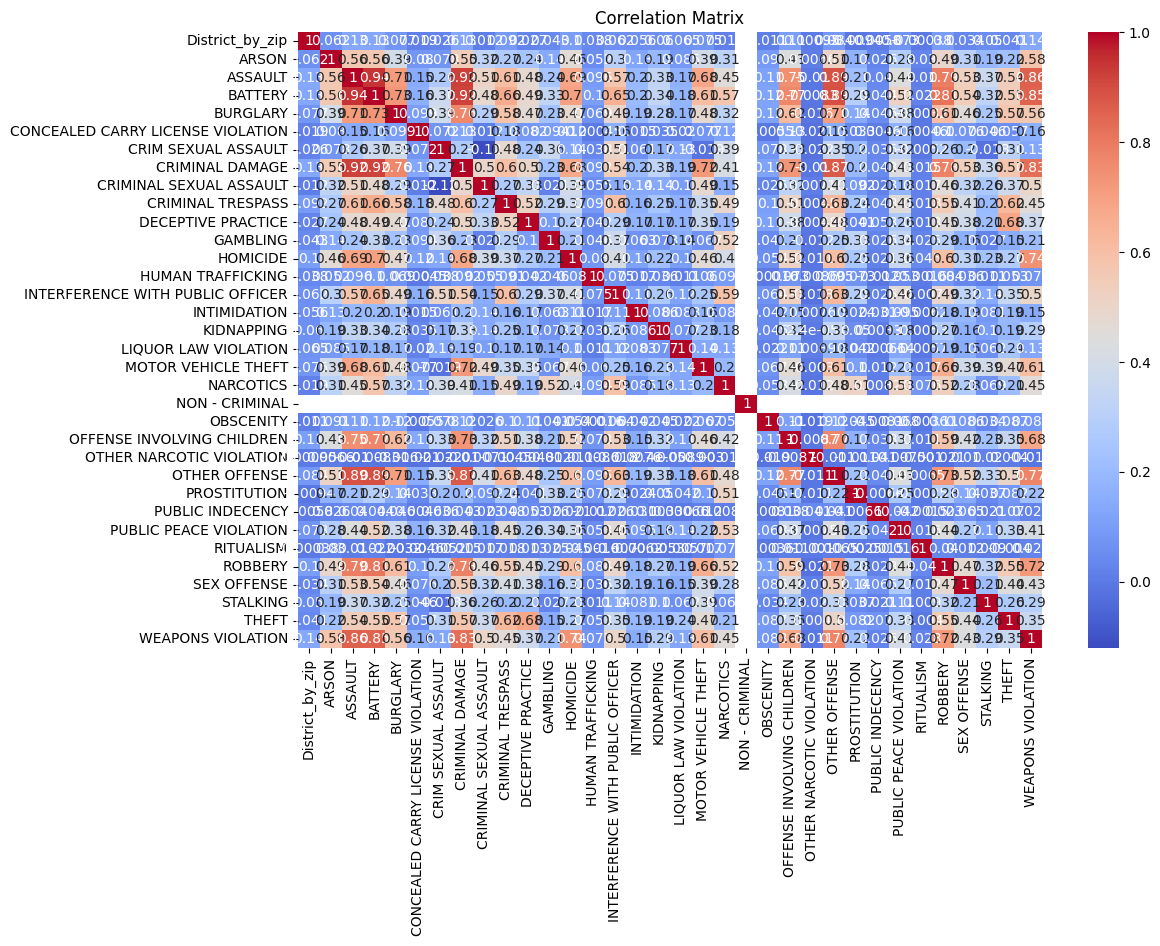

In [28]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_array, annot=True, cmap="coolwarm", xticklabels=numeric_cols, yticklabels=numeric_cols)
plt.title("Correlation Matrix")
plt.show()

In [29]:
correlation_pairs = []
num_columns = len(numeric_cols)
for i in range(num_columns):
    for j in range(i + 1, num_columns):
        correlation_pairs.append((numeric_cols[i], numeric_cols[j], corr_array[i][j]))

sorted_pairs = sorted(correlation_pairs, key=lambda x: abs(x[2]), reverse=True)

for col1, col2, corr_value in sorted_pairs[:10]: 
    print(f"{col1} and {col2}: {corr_value:.4f}")

ASSAULT and BATTERY: 0.9431
ASSAULT and CRIMINAL DAMAGE: 0.9228
ARSON and ASSAULT: 0.5644
ARSON and BATTERY: 0.5626
ARSON and CRIMINAL DAMAGE: 0.5451
ARSON and HOMICIDE: 0.4621
District_by_zip and ASSAULT: 0.1333
District_by_zip and BATTERY: 0.1322
District_by_zip and CRIMINAL DAMAGE: 0.1290
District_by_zip and HOMICIDE: 0.1004


In [43]:
traffic_crashes_by_year = traffic_crashes.groupBy("Year").count()
crimes_by_year = crimes.groupBy("Year").count()
traffic_crashes_by_year = traffic_crashes_by_year.withColumnRenamed("count", "count_traffic_crashes")
crimes_by_year = crimes_by_year.withColumnRenamed("count", "count_crimes")
joined_by_year = traffic_crashes_by_year.join(crimes_by_year, on=["Year"], how="left")
joined_by_year.orderBy(col("Year").asc()).show()

[Stage 510:==================================================>  (189 + 2) / 200]

+----+---------------------+------------+
|Year|count_traffic_crashes|count_crimes|
+----+---------------------+------------+
|2018|               118950|      269070|
|2019|               117762|      261554|
|2020|                92093|      212519|
|2021|               108765|      209404|
|2022|               108410|      239647|
|2023|               110746|      262748|
|2024|               111937|      254216|
+----+---------------------+------------+



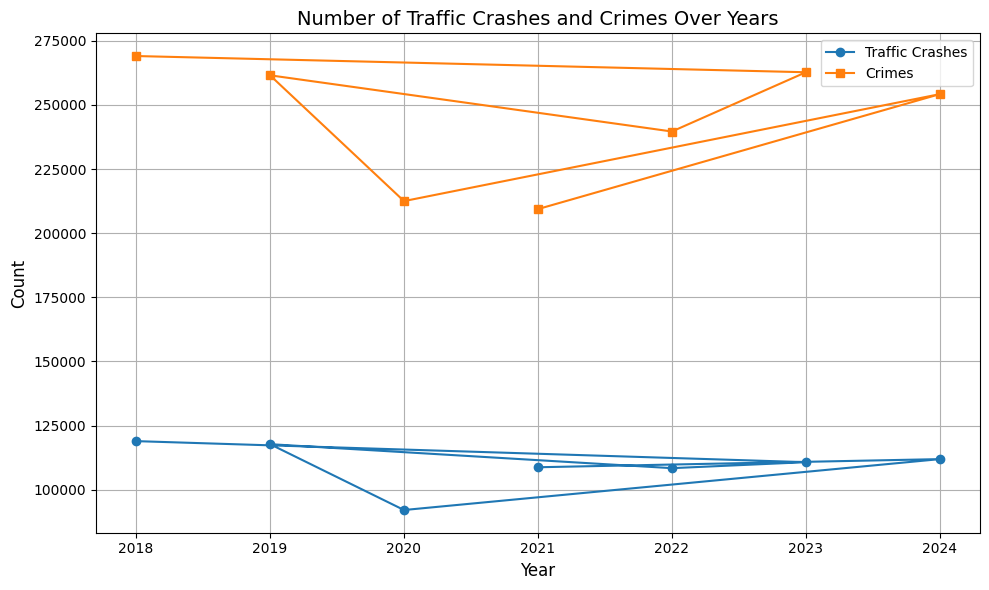

In [49]:
# joined_by_year = joined_by_year.toPandas()
plt.figure(figsize=(10, 6))
plt.plot(joined_by_year['Year'], joined_by_year['count_traffic_crashes'], label='Traffic Crashes', marker='o')
plt.plot(joined_by_year['Year'], joined_by_year['count_crimes'], label='Crimes', marker='s')

plt.title('Number of Traffic Crashes and Crimes Over Years', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(joined_by_year['Year'])  
plt.tight_layout()
plt.show()

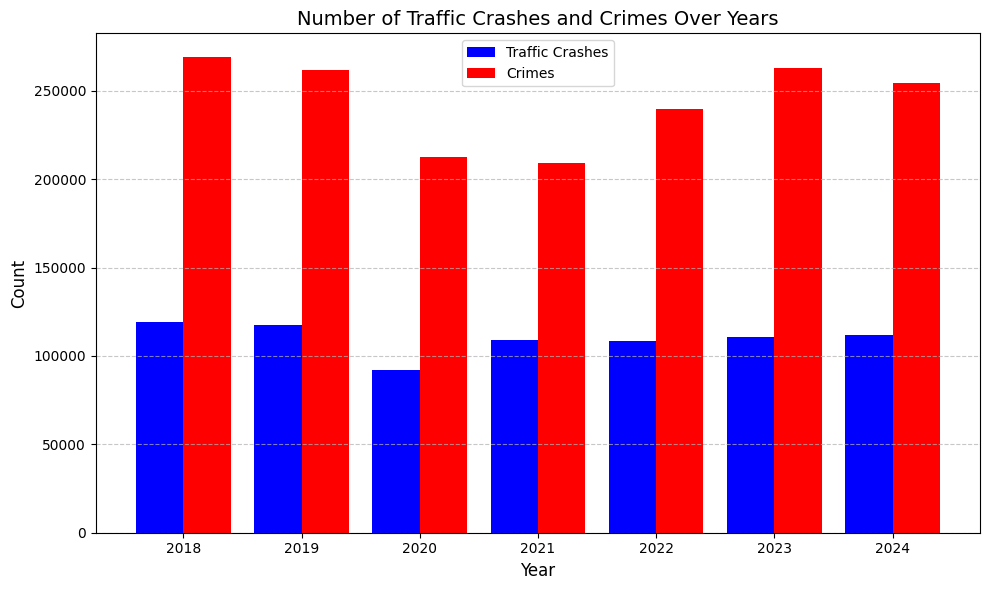

In [52]:
plt.figure(figsize=(10, 6))

plt.bar(joined_by_year['Year'] - 0.2, joined_by_year['count_traffic_crashes'], width=0.4, label='Traffic Crashes', color='blue')
plt.bar(joined_by_year['Year'] + 0.2, joined_by_year['count_crimes'], width=0.4, label='Crimes', color='red')

plt.title('Number of Traffic Crashes and Crimes Over Years', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(joined_by_year['Year'])  
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()